In [17]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import os
import librosa
import librosa.display as lplt
import IPython
import glob

from tqdm import tqdm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
from collections import Counter
from visualkeras import layered_view
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import layers
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report

## Part 1: Data visualization

### 1.1 Wav files (First track in blues)

In [18]:
audio = "archive/Data/genres_original/blues/blues.00000.wav"
#Load & decode the audio as a time series, where sr represents the sampling rate
wave , sr = librosa.load(audio)
print(type(wave), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [19]:
# Print file information
print(librosa.load(audio, sr=sr))
print('data shape:', np.shape(wave))
print('Sample rate:', sr)
print('Len of audio', 661797/22050)

(array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
       -0.06106567, -0.06417847], dtype=float32), 22050)
data shape: (661794,)
Sample rate: 22050
Len of audio 30.0134693877551


In [20]:
# Play the audio
IPython.display.Audio(wave, rate=sr)

#### Waveform
Waveform is the basic way to represent a signal, which records the shape of the signal according to time.

Although waveforms are common and contain all the info of a sound, they are highly aggregated, making it difficult to derive efficient information directly from them.

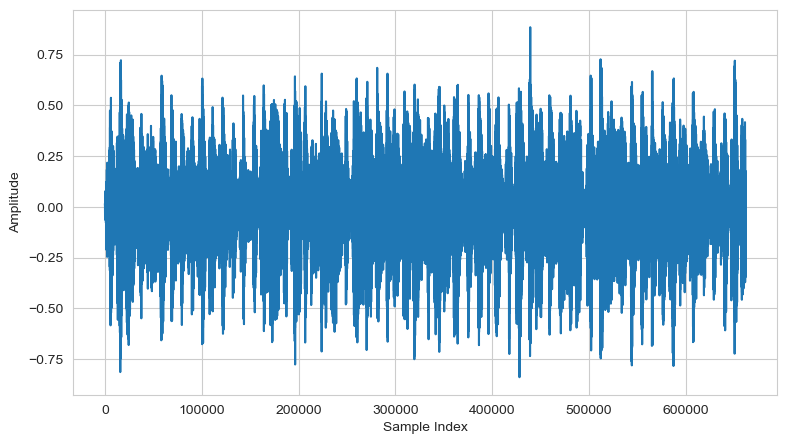

In [21]:
# Print the waveform and spectrogram
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(wave)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.show()

#### Tempo
Tempo is estimated on Waveform from local loudness peaks.

In [22]:
tempo, _ = librosa.beat.beat_track(y=wave, sr = sr)
tempo

123.046875

#### Fourier transform
It converts signals from the time domain to the frequency domain.

The result of the Fourier transform is spectrum which includes the signal strength at different frequencies. However, the Fourier transform is still not very useful for identifying music types.

(1025, 1293)


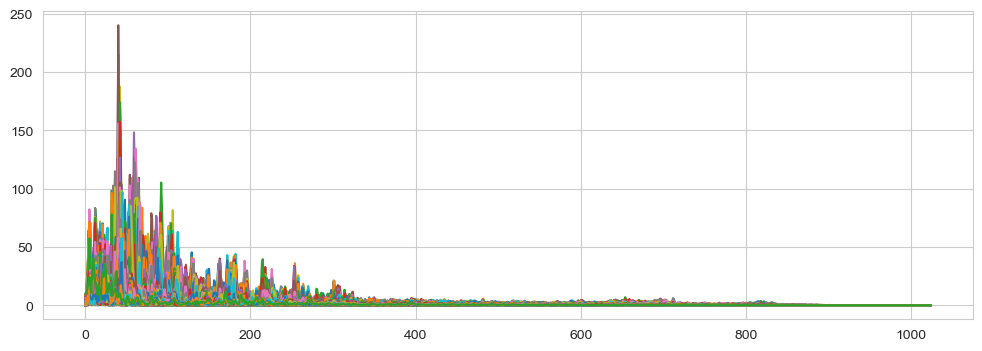

In [23]:
ws_fft = 2048 # window size
dt = np.abs(librosa.stft(wave, n_fft=ws_fft))
print(np.shape(dt))
plt.figure(figsize=(12,4))
plt.plot(dt)
plt.show()

#### Short-time Fourier Transform
The short-time Fourier transform is a frame-like tool that provides information for analysis at a specific time.

Since the Fourier transform can only act on a period of time, the short-time Fourier transform requires first dividing the audio into many small segments, and then performing Fourier transform on each part. The overall process can basically be determined by the step size and window size. Since adjacent segments can overlap, the window size can be larger than the step size.

Through short-time Fourier transform, the audio will be turned into a piece of three-dimensional data. The three dimensions are time, frequency, and intensity.


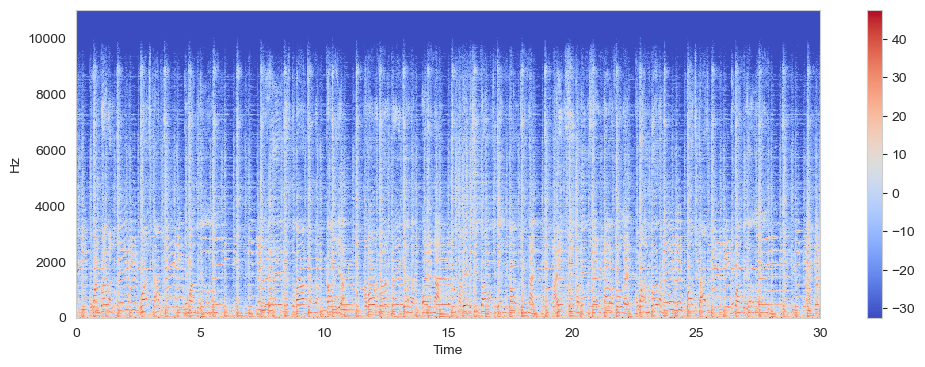

In [24]:
stft = librosa.stft(wave)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#### Mel Spectrogram
In general, the Mel spectrum is the result of using several frequency filters based on the human ear's sensitivity on the results of the short-time Fourier transform. Since people are more sensitive to low-frequency sounds, there are generally more filters in these low-frequency parts to increase the amount of low-frequency information in the results. On the opposite side, there are fewer filters in the high-frequency portion, so more high-frequency information is eliminated from the result.

In practice, both the spectrum and the Mel filter bank will be expressed in matrix form, and the filtering will be calculated by matrix multiplication.

Mel spectrum can thus reduce the amount of data and improve the learning speed. In addition, the design for human ear sensitivity will also alleviate accuracy problems caused by the lack of some information.

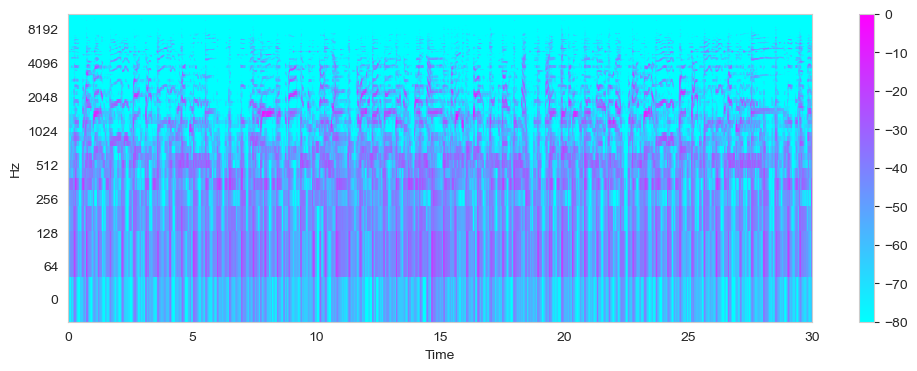

In [25]:
mel_s = librosa.feature.melspectrogram(y=wave, sr=sr)
mel_s_db = librosa.amplitude_to_db(mel_s, ref=np.max)
plt.figure(figsize=(12,4))
lplt.specshow(mel_s_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.show()

#### Mel-Frequency Cepstral Coefficients:
MFCC is a set of highly correlated values generated from the Mel spectrum. Because they are highly correlated, MFCC is not that suitable for some technical fields such as deep learning that are not sensitive to highly correlated inputs.

D:\miniconda3\envs\MLA1\Lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
D:\miniconda3\envs\MLA1\Lib\site-packages\sklearn\preprocessing\_data.py:266: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


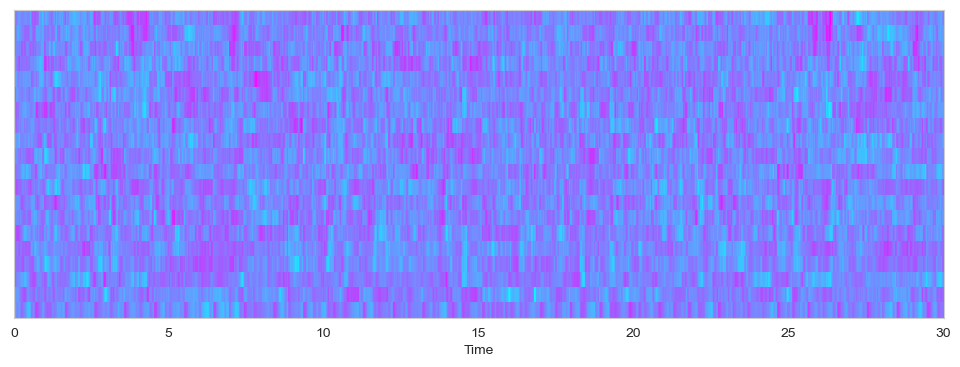

In [26]:
mfccs = librosa.feature.mfcc(y=wave,sr=sr)
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
plt.figure(figsize=(12,4))
lplt.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool')
plt.show()

#### Chroma
Chroma is extracted musical tones from audio. By extracting ordinary musical sounds after short-time Fourier transform, a piece of data similar to a musical sheet can be obtained.

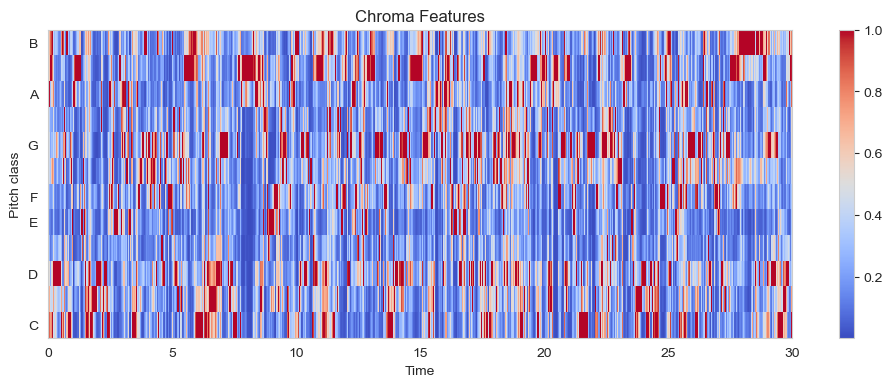

In [27]:
chroma = librosa.feature.chroma_stft(y=wave, sr=sr)
plt.figure(figsize=(12,4))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

#### Harmony
When Chroma is extracted, harmony features can also be extracted based on their appearance time and order.

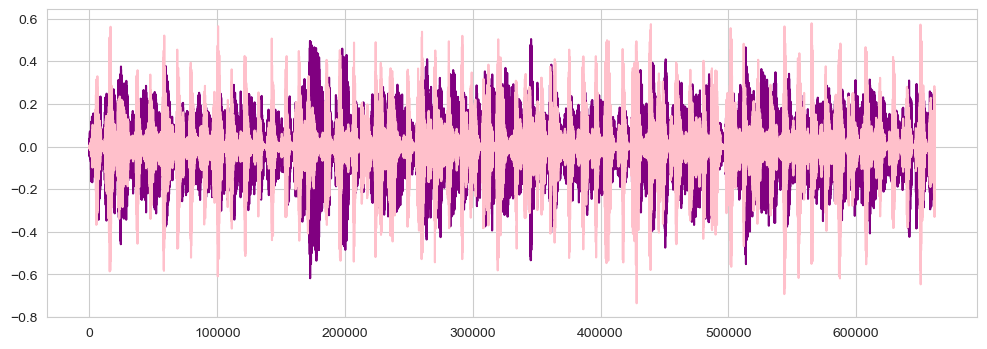

In [28]:
y_harm, y_perc = librosa.effects.hpss(wave)
plt.figure(figsize = (12, 4))
plt.plot(y_harm, color = 'purple')
plt.plot(y_perc, color = 'pink')
plt.show()

#### Spectral Centroid
Spectral Centroid is based on statistics of frequency distribution and energy distribution of sound signals. Its numerical value describes the brightness of audio and is often used in the analysis of musical instrument timbre.

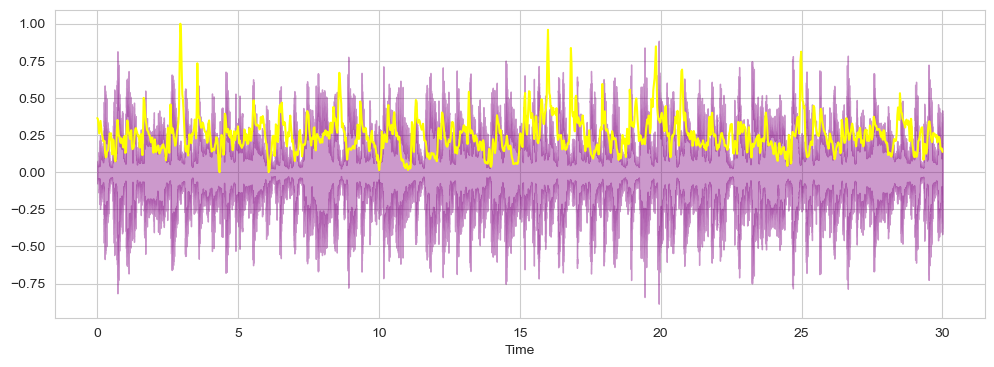

In [29]:
spectral_c = librosa.feature.spectral_centroid(y=wave, sr=sr)[0]
plt.figure(figsize = (12, 4))
frames = range(len(spectral_c))
time = librosa.frames_to_time(frames)
lplt.waveshow(y=wave, sr=sr, alpha=0.4, color = 'purple')
plt.plot(time, sklearn.preprocessing.minmax_scale(spectral_c), color='yellow')
plt.show()

#### Zero cross rate
Zero Cross Rate is calculated after dividing the audio into segments, and its value is the number of times the signal in the audio segment crosses the 0 value. This feature can help distinguish different sounds, such as unvoiced sound and voiced sound in speech recognition.

In [30]:
# Print the total zero crossings
zero_cross = librosa.zero_crossings(wave, pad=False)
print(sum(zero_cross))

55031


#### Rolloff

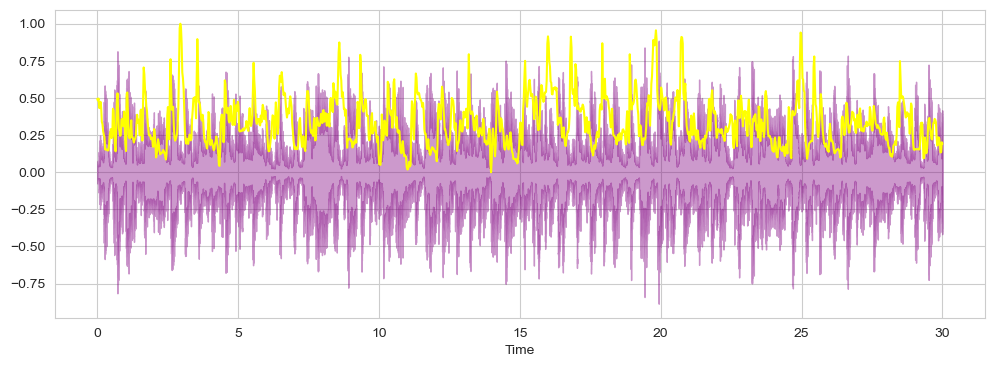

In [31]:
spectral_c = librosa.feature.spectral_centroid(y=wave, sr=sr)[0]
frames = range(len(spectral_c))
time = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

spectral_r = librosa.feature.spectral_rolloff(y=wave, sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveshow(wave, sr=sr, alpha=0.4, color='Purple')
plt.plot(time, normalize(spectral_r), color='yellow')
plt.show()

### 1.2 CSV file

In [32]:
# Read the data
data = pd.read_csv("cache/features_30_sec.csv")

In [33]:
# Print the genres of music
genres = 'archive/Data'
print(list(os.listdir(f'{genres}/genres_original/')))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [34]:
# Print the data outline
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav      30          0.349951         0.088752  0.130192   
1  blues.00001.wav      30          0.340945         0.094968  0.095892   
2  blues.00002.wav      30          0.363562         0.085277  0.175494   
3  blues.00003.wav      30          0.404848         0.094018  0.141139   
4  blues.00004.wav      30          0.308598         0.087850  0.091540   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002830             1784.416546          129739.837401   
1  0.002374             1529.871314          376011.650101   
2  0.002753             1552.637786          156538.294709   
3  0.006340             1070.110059          184506.655421   
4  0.002305             1835.507009          343334.237041   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.657106            85829.345908  ...   52.464140   
1              2038.612143           213889.873843  ...   55.364292   
2              1747.382028            76150.688778  ...   40.620193   
3              1596.244204           166637.568438  ...   44.456993   
4              1748.367477            88460.061228  ...   86.012780   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.688358   36.564606    -0.409329   41.643623    -2.298869   55.076675   
1    -0.717028   60.113300     0.292333   48.137740    -0.285717   51.131210   
2    -7.721793   47.700275    -1.816497   52.418175    -3.434354   46.630066   
3    -3.320056   50.236970     0.637263   37.351920    -0.617507   37.291164   
4    -5.453736   75.328180    -0.924468   53.577564    -4.408076   62.928513   

   mfcc20_mean  mfcc20_var  label  
0     1.219947   46.975636  blues  
1     0.532144   45.823235  blues  
2    -2.231391   30.626228  blues  
3    -3.406940   31.988438  blues  
4   -11.701833   55.215122  blues  

[5 rows x 58 columns]

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 999 non-null    object 
 1   length                   999 non-null    int64  
 2   chroma_stft_mean         999 non-null    float64
 3   chroma_stft_var          999 non-null    float64
 4   rms_mean                 999 non-null    float64
 5   rms_var                  999 non-null    float64
 6   spectral_centroid_mean   999 non-null    float64
 7   spectral_centroid_var    999 non-null    float64
 8   spectral_bandwidth_mean  999 non-null    float64
 9   spectral_bandwidth_var   999 non-null    float64
 10  rolloff_mean             999 non-null    float64
 11  rolloff_var              999 non-null    float64
 12  zero_crossing_rate_mean  999 non-null    float64
 13  zero_crossing_rate_var   999 non-null    float64
 14  harmony_mean             9

In [36]:
data.shape

(999, 58)

In [37]:
data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var                  float64
mfcc6_mean                 float64
mfcc6_var           

In [38]:
# Remove unnecessary feature data
data = data.drop(labels='filename', axis=1)
data = data.drop(labels='length', axis=1)

## Part 2: Feature Explore and Processing

### 2.1 Explore feature correlations

#### feature correlations

In [39]:
# Use feature_30_sec.csv to explore the features
data2 = data
data2.head()

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.349951         0.088752  0.130192  0.002830   
1          0.340945         0.094968  0.095892  0.002374   
2          0.363562         0.085277  0.175494  0.002753   
3          0.404848         0.094018  0.141139  0.006340   
4          0.308598         0.087850  0.091540  0.002305   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1784.416546          129739.837401              2002.657106   
1             1529.871314          376011.650101              2038.612143   
2             1552.637786          156538.294709              1747.382028   
3             1070.110059          184506.655421              1596.244204   
4             1835.507009          343334.237041              1748.367477   

   spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_var  \
0            85829.345908   3806.418650  9.013297e+05  ...   52.464140   
1           213889.873843   3548.986873  2.976792e+06  ...   55.364292   
2            76150.688778   3041.089944  7.829465e+05  ...   40.620193   
3           166637.568438   2185.061787  1.494194e+06  ...   44.456993   
4            88460.061228   3581.003346  1.572133e+06  ...   86.012780   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.688358   36.564606    -0.409329   41.643623    -2.298869   55.076675   
1    -0.717028   60.113300     0.292333   48.137740    -0.285717   51.131210   
2    -7.721793   47.700275    -1.816497   52.418175    -3.434354   46.630066   
3    -3.320056   50.236970     0.637263   37.351920    -0.617507   37.291164   
4    -5.453736   75.328180    -0.924468   53.577564    -4.408076   62.928513   

   mfcc20_mean  mfcc20_var  label  
0     1.219947   46.975636  blues  
1     0.532144   45.823235  blues  
2    -2.231391   30.626228  blues  
3    -3.406940   31.988438  blues  
4   -11.701833   55.215122  blues  

[5 rows x 56 columns]

#### Correlation heatmap for feature means

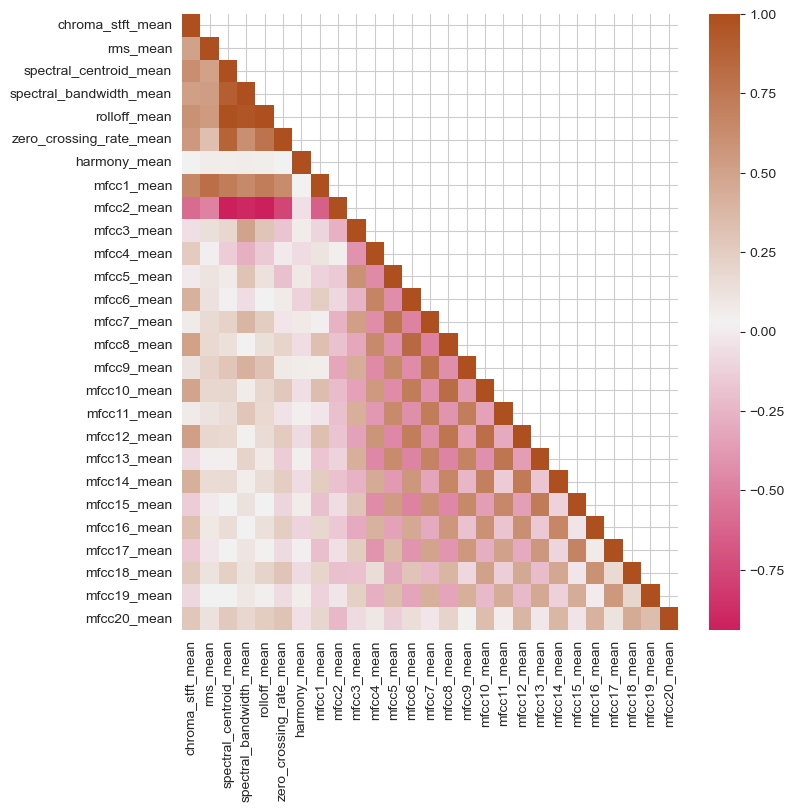

In [40]:
# Print a correlation heatmap (masked up triangle)
cols = [col for col in data2.columns if 'mean' in col]
corr = data2[cols].corr()

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

mask = np.zeros_like(corr)
for i in range(1,len(mask)):
  for j in range(0,i):
    mask[j][i] = True

plt.figure(figsize=(8, 8))
sns.heatmap(corr, cmap=cmap, mask=mask)

plt.show()

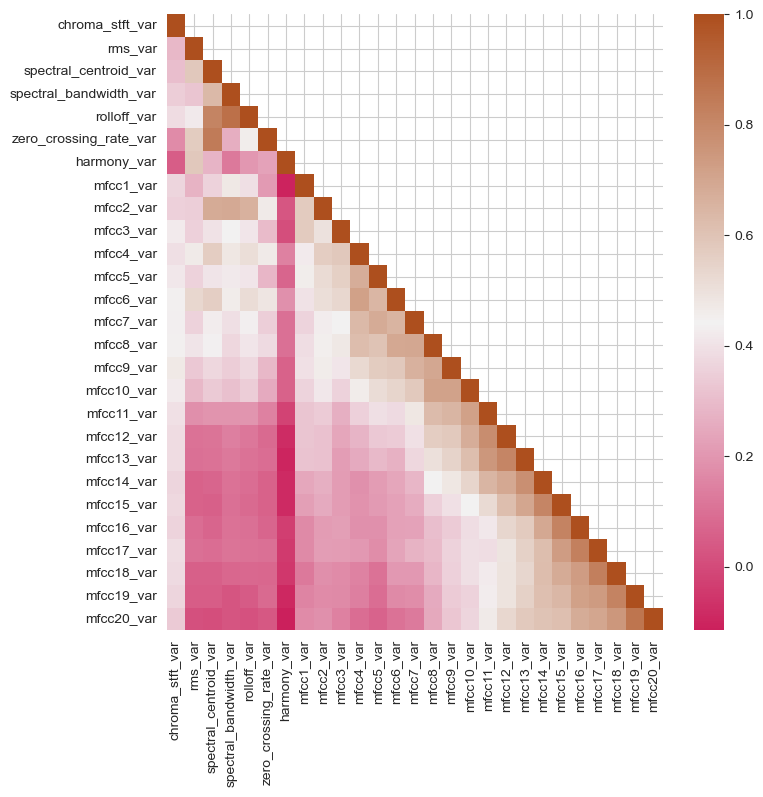

In [41]:
# Print a correlation heatmap (masked up triangle)
cols = [col for col in data2.columns if 'var' in col]
corr = data2[cols].corr()

cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

mask = np.zeros_like(corr)
for i in range(1,len(mask)):
  for j in range(0,i):
    mask[j][i] = True

plt.figure(figsize=(8, 8))
sns.heatmap(corr, cmap=cmap, mask=mask)

plt.show()

#### Drop the low correlation features.

In [42]:
columns_to_drop = [f'mfcc{i}_{stat}' for i in range(11, 21) for stat in ['mean', 'var']]

data2 = data2.drop(columns = columns_to_drop, errors='ignore')

data2.head()

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0          0.349951         0.088752  0.130192  0.002830   
1          0.340945         0.094968  0.095892  0.002374   
2          0.363562         0.085277  0.175494  0.002753   
3          0.404848         0.094018  0.141139  0.006340   
4          0.308598         0.087850  0.091540  0.002305   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1784.416546          129739.837401              2002.657106   
1             1529.871314          376011.650101              2038.612143   
2             1552.637786          156538.294709              1747.382028   
3             1070.110059          184506.655421              1596.244204   
4             1835.507009          343334.237041              1748.367477   

   spectral_bandwidth_var  rolloff_mean   rolloff_var  ...   mfcc6_var  \
0            85829.345908   3806.418650  9.013297e+05  ...   89.169586   
1           213889.873843   3548.986873  2.976792e+06  ...  156.470440   
2            76150.688778   3041.089944  7.829465e+05  ...   74.469330   
3           166637.568438   2185.061787  1.494194e+06  ...  126.882340   
4            88460.061228   3581.003346  1.572133e+06  ...  134.796740   

   mfcc7_mean  mfcc7_var  mfcc8_mean   mfcc8_var  mfcc9_mean   mfcc9_var  \
0  -13.692060   67.60479   15.339378   69.063070  -12.283618   82.152500   
1   -8.555368  200.96965   23.355938  142.372480  -10.101037  166.232130   
2  -13.644712  106.68324   11.623112  106.627710  -11.775920   65.685420   
3   -4.828873  156.06218    9.297849   81.170860   -0.753142   92.361916   
4  -23.357162   93.30083    0.500523  124.761475  -11.804770  129.988720   

   mfcc10_mean  mfcc10_var  label  
0    10.973775   63.400475  blues  
1    11.906445  104.358574  blues  
2     9.700466   67.845474  blues  
3     8.147393   71.223050  blues  
4     1.203877   99.795204  blues  

[5 rows x 36 columns]

### 2.2 Explore the tempo distribution of different genres

#### Box Plot for Genres Distributions

C:\Users\milu\AppData\Local\Temp\ipykernel_2080\460506829.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl')


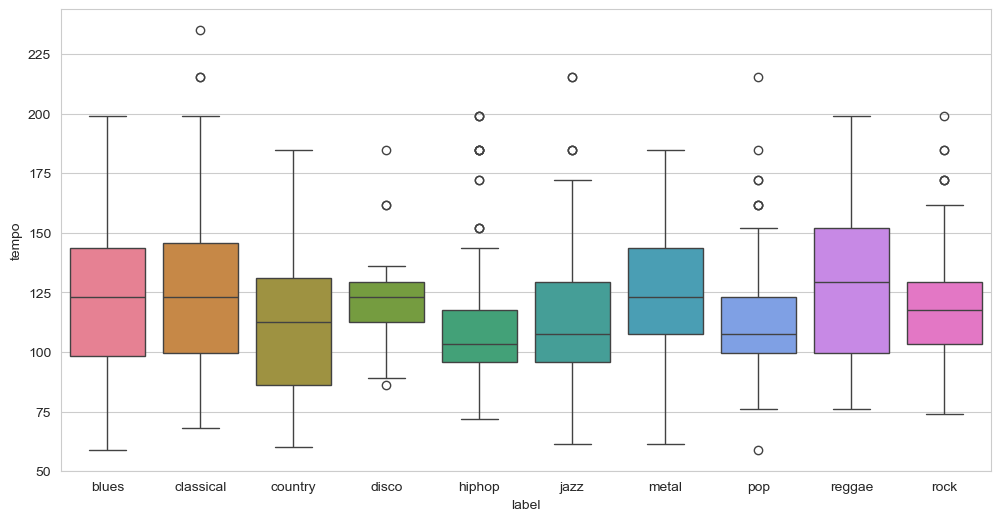

In [43]:
# Print a box plot
x = data2[["label", "tempo"]]

f, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl')
plt.show()

With this graph we can find some outliers.

#### Outlier processing

Use the quartile method to find outliers

In [44]:
data_to_test = data2[['tempo']]

def delete_outliers(data, cloms, n):      
    # saves the outlier's index       
    indices = []      

    for clom in cloms:
        q1 = np.percentile(data[clom],25)       
        q3 = np.percentile(data[clom],75)    

        # IQR is the aera between q1 and q3   
        IQR = q3 - q1                        
        outlier_step = 1.5 * IQR  

        outlier_colm = data[(data[clom] < q1 - outlier_step) | (data[clom] > q3 + outlier_step)].index  
        indices.extend(outlier_colm)
        
    indices = Counter(indices)
    outliers_ = list(k for k, v in indices.items() if v >= n) 
    return outliers_

Q1 = 25%	Q3 = 75%	IQR = Q3 - Q1

Lower Bound = Q1 - 1.5 * IQR

Upper Bound = Q3 + 1.5 * IQR

Values outside the bound will be marked as outliers.

In [45]:
outliers = delete_outliers(data_to_test, ['tempo'], 1)
len(outliers)

13

In [46]:
data2 = data2.drop(outliers, axis=0).reset_index(drop=True)
data2.shape

(986, 36)

### 2.3 EDA

#### Normalization

Use MinMaxScaler() to normalize the data to the (0,1) unity dimension.

In [47]:
data2 = data
data2 = data2.iloc[0:, 1:]
# Get labels
y = data2['label']
# Get features without label
x = data2.loc[:, data2.columns != 'label']

cols = x.columns
# Use min max scaler
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(scaled, columns=cols)
x


chroma_stft_var  rms_mean   rms_var  spectral_centroid_mean  \
0           0.695991  0.318208  0.102011                0.314186   
1           0.793926  0.230836  0.085539                0.248324   
2           0.641242  0.433602  0.099203                0.254214   
3           0.778957  0.346093  0.228690                0.129362   
4           0.681784  0.219753  0.083049                0.327406   
..               ...       ...       ...                     ...   
994         0.565860  0.188934  0.012332                0.372176   
995         0.481127  0.181251  0.021128                0.371522   
996         0.483131  0.194388  0.011492                0.389934   
997         0.739396  0.200124  0.043391                0.214353   
998         0.649573  0.125254  0.011998                0.268894   

     spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0                 0.040225                 0.422546                0.109168   
1                 0.121568                 0.436324                0.296395   
2                 0.049076                 0.324725                0.095018   
3                 0.058314                 0.266809                0.227311   
4                 0.110775                 0.325102                0.113014   
..                     ...                      ...                     ...   
994               0.090564                 0.462281                0.113246   
995               0.057300                 0.447672                0.103454   
996               0.073906                 0.393514                0.092861   
997               0.076839                 0.351714                0.143160   
998               0.136899                 0.343709                0.159570   

     rolloff_mean  rolloff_var  zero_crossing_rate_mean  ...  mfcc16_mean  \
0        0.385634     0.102533                 0.242429  ...     0.563725   
1        0.353158     0.342576                 0.135677  ...     0.569975   
2        0.289086     0.088841                 0.215701  ...     0.622105   
3        0.181096     0.171102                 0.045860  ...     0.564637   
4        0.357197     0.180117                 0.315253  ...     0.383421   
..            ...          ...                      ...  ...          ...   
994      0.442113     0.139717                 0.266924  ...     0.599883   
995      0.428620     0.118792                 0.300078  ...     0.666124   
996      0.413934     0.091318                 0.395545  ...     0.601299   
997      0.285753     0.152444                 0.106787  ...     0.441532   
998      0.314974     0.201184                 0.215658  ...     0.599299   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0      0.112647     0.541429    0.057951     0.422907    0.082832   
1      0.120199     0.575256    0.118023     0.448542    0.103326   
2      0.081805     0.331309    0.086358     0.371498    0.116833   
3      0.091796     0.484604    0.092829     0.461143    0.069288   
4      0.200009     0.410296    0.156835     0.404087    0.120492   
..          ...          ...         ...          ...         ...   
994    0.093252     0.137029    0.070922     0.528219    0.066948   
995    0.064248     0.222209    0.064778     0.506271    0.052443   
996    0.063385     0.152543    0.057393     0.563969    0.064893   
997    0.096675     0.446255    0.076037     0.494873    0.059834   
998    0.129953     0.353915    0.152664     0.438640    0.192984   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0       0.488195    0.109636     0.599323    0.078526  
1       0.548838    0.099261     0.579837    0.076211  
2       0.453991    0.087425     0.501540    0.045689  
3       0.538843    0.062868     0.468235    0.048425  
4       0.424659    0.130283     0.233225    0.095074  
..           ...         ...          ...         ...  
994     0.355028    0.109014     0.530782    0.084601  
995     0.332509    0.067900     0.48

#### PCA

Using PCA() to 2 component for later visualization. The component1 is the direction with the highest variability of the original data, and the component2 is the direction that is orthogonal (perpendicular) to the first principal component and has the second highest variability.

In [48]:
# Use PCA to 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
# Create a new data form to save data after pca
pca_data = pd.DataFrame(data = principal_components, columns=['Pc1', 'Pc2'])

# Combined data
final_data = pd.concat([pca_data, y], axis = 1)

pca.explained_variance_ratio_

array([0.25631786, 0.20770375])

#### Scatterplot

<Axes: xlabel='Pc1', ylabel='Pc2'>

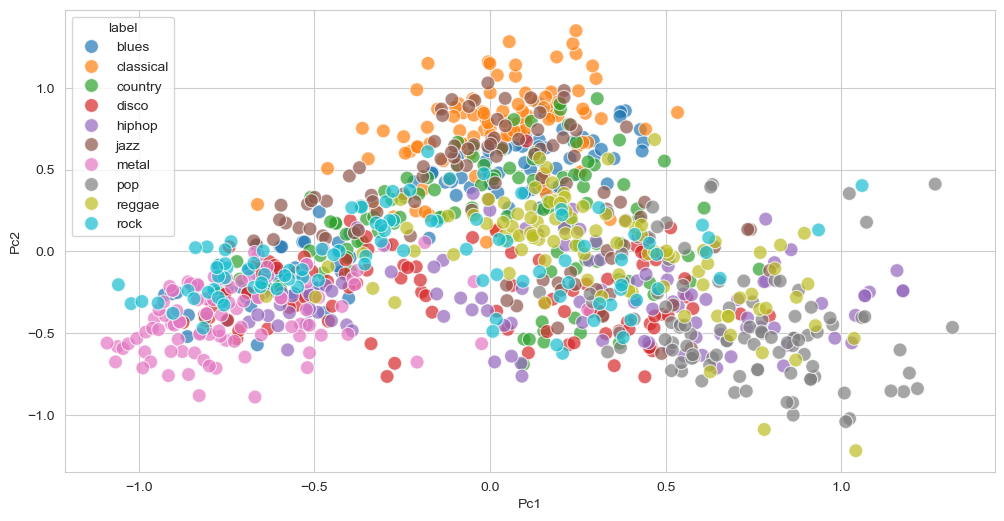

In [49]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Pc1', y='Pc2', data=final_data, hue='label', alpha=0.7,s=100)

In the figure we can find a more even distribution of the different genres, and in order to maintain data integrity, we did not manipulate the data further in this step.

## Part 3: Data preprocessing

### 3.1 Data for CNN (From wav files)

#### Use VGGish
VGGish is a feature extractor released by the Google team in 2017 based on VGG convolutional network.

VGG is a classic convolutional network and a verifier that the effect of convolutional neural networks improves with depth. It improves accuracy by using multiple layers of 3 by 3 convolution kernels instead of larger convolution kernels with fewer layers. 

For audio signal processing, VGGish uses VGG on Mel Spectrogram and outputs the results directly as features. This result can be further applied to other deep learning models.

Most of the VGGish models currently used use the pre-trained model from the Google team. The reason is that the pre-trained model is trained through a sophisticated large-scale audio data set (AudioSet) and already has quite good capabilities.

In [50]:
# Load the vggish model.
vggish = hub.load('https://kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1')

In [51]:
# Function to extract audio features using VGGish
def extractFeatures(audioFile):
    try:
        # Loading audio file
        waveform, sr = librosa.load(audioFile)
        
        # Trimming silence
        waveform, _ = librosa.effects.trim(waveform)
        
        # Extracting features using VGGish
        return vggish(waveform).numpy()
    except:
        return None

In [52]:
# Root directory containing the audio files
root = 'archive\Data\genres_original'
data = []
import pickle

using_cache = True

if os.path.exists("cache/vggish_features_data_obj.pkl") and using_cache:
    with open('cache/vggish_features_data_obj.pkl', 'rb') as file:
        data = pickle.load(file)
else:
    # Iterating through the folders and files to extract features
    for folder in os.listdir(root):
        folderPath = os.path.join(root, folder)
        
        for file in tqdm(os.listdir(folderPath), desc = f'Processing folder {folder}'):
            filePath = os.path.join(folderPath, file)
            features = extractFeatures(filePath)
            
            if features is not None:
                data.append([features, folder])
    # cache data obj
    with open('vggish_features_data.pkl', 'wb') as file:
        pickle.dump(data, file)

In [53]:
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

Features  Class
0  [[-0.3451769, 0.3073998, 0.21782884, -0.281157...  blues
1  [[-0.1674901, 0.25671566, 0.1906853, -0.035838...  blues
2  [[-0.7940438, 0.89984, 0.4954066, -0.2639591, ...  blues
3  [[-0.8552463, 0.5541471, 0.40423268, -0.232730...  blues
4  [[-0.66421735, -0.22497997, 0.002530098, -0.08...  blues

In [54]:
data.shape

(999, 2)

#### Check the data balance

C:\Users\milu\AppData\Local\Temp\ipykernel_2080\3320176916.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = data['Class'], palette = 'viridis')


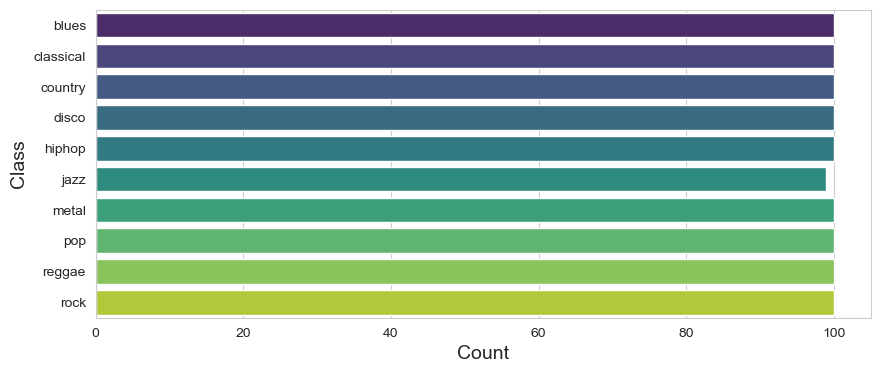

In [55]:
plt.figure(figsize = (10, 4))
sns.countplot(y = data['Class'], palette = 'viridis')
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

In [56]:
# Alignment feature number
x = data['Features'].tolist()
x = pad_sequences(x, dtype = 'float32', padding = 'post', truncating = 'post')
x.shape

(999, 43, 128)

#### Label encoder target variable

In [57]:
# Encode the label data to int
encoder = LabelEncoder()
y = data['Class']

y = encoder.fit_transform(y)
y = to_categorical(y)

#### Split data into traing and teating set

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

In [59]:
print(x_train.shape)
print(y_train.shape)

(749, 43, 128)
(749, 10)


### 3.1 Data for other models (From csv files)

In [60]:
data2.head()

chroma_stft_var  rms_mean   rms_var  spectral_centroid_mean  \
0         0.088752  0.130192  0.002830             1784.416546   
1         0.094968  0.095892  0.002374             1529.871314   
2         0.085277  0.175494  0.002753             1552.637786   
3         0.094018  0.141139  0.006340             1070.110059   
4         0.087850  0.091540  0.002305             1835.507009   

   spectral_centroid_var  spectral_bandwidth_mean  spectral_bandwidth_var  \
0          129739.837401              2002.657106            85829.345908   
1          376011.650101              2038.612143           213889.873843   
2          156538.294709              1747.382028            76150.688778   
3          184506.655421              1596.244204           166637.568438   
4          343334.237041              1748.367477            88460.061228   

   rolloff_mean   rolloff_var  zero_crossing_rate_mean  ...  mfcc16_var  \
0   3806.418650  9.013297e+05                 0.083066  ...   52.464140   
1   3548.986873  2.976792e+06                 0.056044  ...   55.364292   
2   3041.089944  7.829465e+05                 0.076301  ...   40.620193   
3   2185.061787  1.494194e+06                 0.033309  ...   44.456993   
4   3581.003346  1.572133e+06                 0.101500  ...   86.012780   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.688358   36.564606    -0.409329   41.643623    -2.298869   55.076675   
1    -0.717028   60.113300     0.292333   48.137740    -0.285717   51.131210   
2    -7.721793   47.700275    -1.816497   52.418175    -3.434354   46.630066   
3    -3.320056   50.236970     0.637263   37.351920    -0.617507   37.291164   
4    -5.453736   75.328180    -0.924468   53.577564    -4.408076   62.928513   

   mfcc20_mean  mfcc20_var  label  
0     1.219947   46.975636  blues  
1     0.532144   45.823235  blues  
2    -2.231391   30.626228  blues  
3    -3.406940   31.988438  blues  
4   -11.701833   55.215122  blues  

[5 rows x 55 columns]

#### Check data balance

C:\Users\milu\AppData\Local\Temp\ipykernel_2080\1094370103.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = data2['label'], palette = 'viridis')


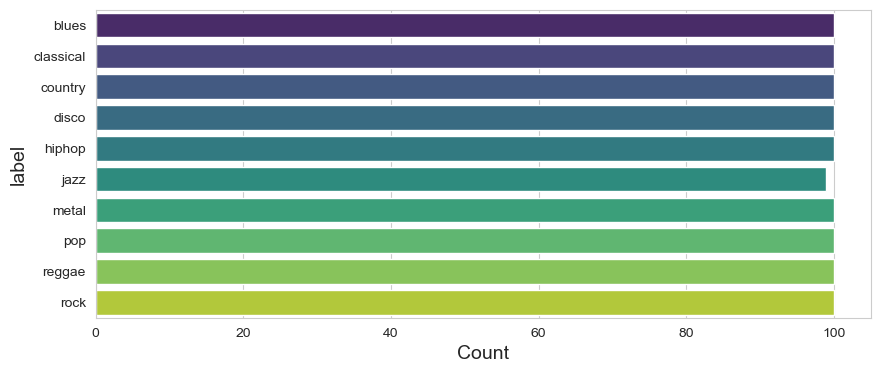

In [61]:
plt.figure(figsize = (10, 4))
sns.countplot(y = data2['label'], palette = 'viridis')
plt.xlabel('Count', fontsize = 14)
plt.ylabel('label', fontsize = 14)
plt.show()

Unbalanced sample of processed data

#### Use SMOTE balance the data

In [62]:
x2 = data2.loc[:, data2.columns != 'label']
y2 = data2['label']

smo = SMOTE()

x2, y2 = smo.fit_resample(x2, y2)

#### Feature Normalization

In [63]:
# Normalize the data
cols = x2.columns
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(x2)
x2 = pd.DataFrame(scaled, columns=cols)

#### Data spliting

In [64]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3,random_state=0)

In [65]:
x_train2.shape, y_test2.shape

((700, 54), (300,))

## Part 4: Modeling

### 4.1 CNN building

#### CNN

In [66]:
def CNN():
    Cnn = Sequential()
    
    # First convolutional layer with batch normalization
    Cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(43,128,1)))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(MaxPooling2D((2, 2)))
    Cnn.add(Dropout(0.2))

    # Second convolutional layer with batch normalization
    Cnn.add(Conv2D(64, (3, 3), padding='same'))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(MaxPooling2D((2, 2)))
    Cnn.add(Dropout(0.3))

    # Third convolutional layer with batch normalization
    Cnn.add(Conv2D(128, (3, 3), padding='same'))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(MaxPooling2D((2, 2)))
    Cnn.add(Dropout(0.4))

    # Flatten and fully connected layer with batch normalization
    Cnn.add(Flatten())
    Cnn.add(Dense(128))
    Cnn.add(BatchNormalization())
    Cnn.add(Activation('relu'))
    Cnn.add(Dropout(0.5))

    # Output layer with softmax activation
    Cnn.add(Dense(10, activation='softmax'))

    return Cnn
Cnn = CNN()

Cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 128, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 43, 128, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 43, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 21, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 64, 64)        1

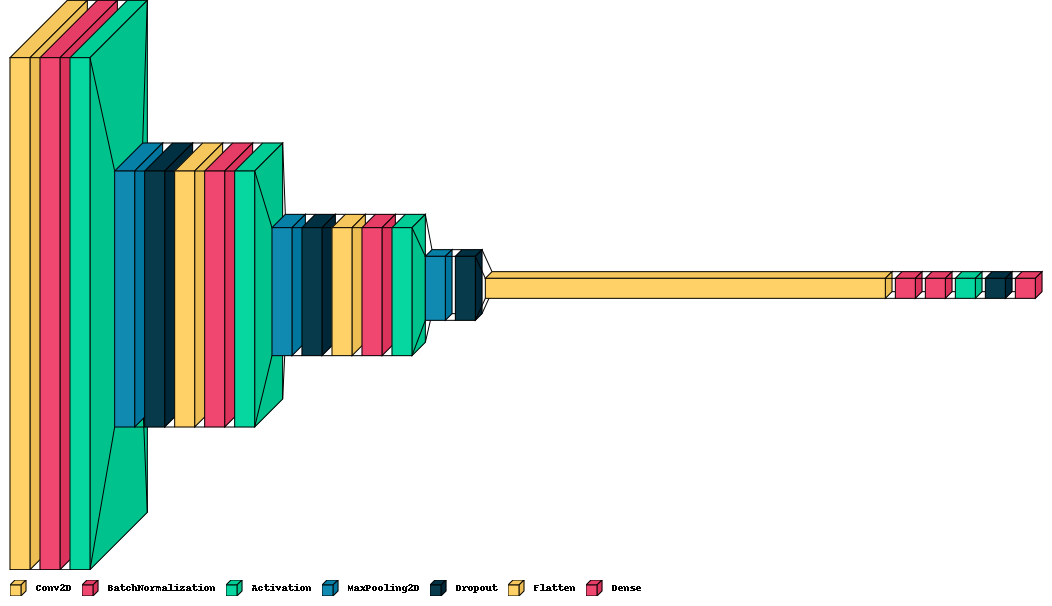

In [67]:
layered_view(Cnn, legend = True)

Model analysis:
Conv2D:
A convolution operation is performed on the 
input features using a given number of 3x3 
Filters.

Extracting low-level features from data.

BatchNormalization:
Normalize the characteristics of each batch.

Accelerated model convergence to improve
training stability.

Activation (‘relu’):
Introducing Nonlinearity to Learn Complex Relationships in 
Features Using ReLU Activation 
Functions.

Helps mitigate gradient disappearance.

MaxPooling2D:
Maximum pooling of 2x2 to reduce the spatial 
dimensionality of features.

Reduced computational effort.

Dropout:
Discard a certain amount of features.

Preventing model overfitting.

Flatten:
Completion of 1D vectorization before Dense.

Dense (First):
Combine features for easy categorization.


#### CNN evaluation

In [68]:
history = Cnn.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 40,
)

Epoch 1/40


24/24 [==============================] - 2s 56ms/step - loss: 1.9590 - accuracy: 0.3658 - val_loss: 2.2788 - val_accuracy: 0.1840
Epoch 2/40
24/24 [==============================] - 1s 50ms/step - loss: 1.1516 - accuracy: 0.6208 - val_loss: 2.9941 - val_accuracy: 0.1200
Epoch 3/40
24/24 [==============================] - 1s 50ms/step - loss: 0.9491 - accuracy: 0.6809 - val_loss: 3.8451 - val_accuracy: 0.1200
Epoch 4/40
24/24 [==============================] - 1s 50ms/step - loss: 0.8179 - accuracy: 0.7236 - val_loss: 4.4520 - val_accuracy: 0.1200
Epoch 5/40
24/24 [==============================] - 1s 50ms/step - loss: 0.7288 - accuracy: 0.7877 - val_loss: 4.7869 - val_accuracy: 0.1200
Epoch 6/40
24/24 [==============================] - 1s 50ms/step - loss: 0.6815 - accuracy: 0.7770 - val_loss: 4.9961 - val_accuracy: 0.1200
Epoch 7/40
24/24 [==============================] - 1s 50ms/step - loss: 0.6430 - accuracy: 0.8011 - val_loss: 5.0798 - val_accuracy: 0.1200
Epoch 8/40
24/24 [======

<Axes: >

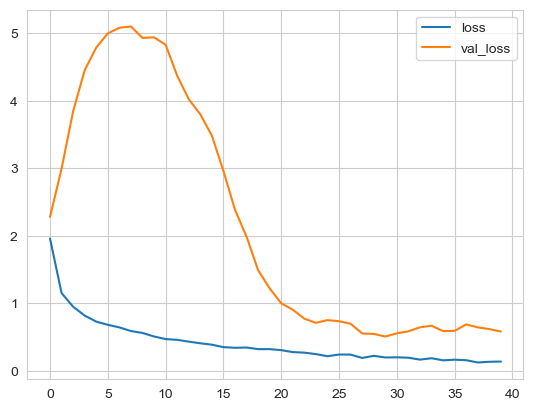

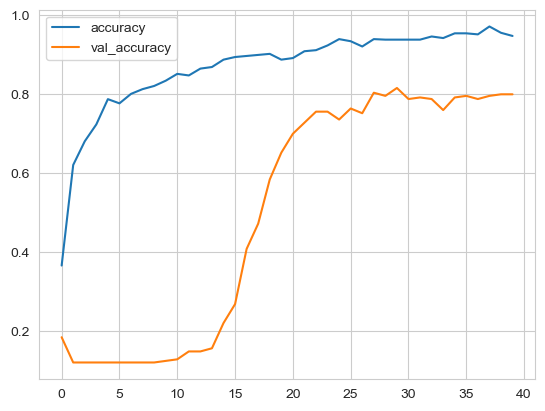

In [69]:
historyData = pd.DataFrame(history.history)
historyData.loc[:,['loss', 'val_loss']].plot()
historyData.loc[:, ['accuracy', 'val_accuracy']].plot()

### 4.2 Models building

#### Pulling models from the sklearn library

In [70]:
# Decision trees
Tree = DecisionTreeClassifier()

# Random Forest
Rf = RandomForestClassifier()

# Logistic Regression
Lr = LogisticRegression()

#### Evaluation function

In [71]:
def model_evaluation(model, title):
    model.fit(x_train2, y_train2)
    preds = model.predict(x_test2)
    print(confusion_matrix(y_test2, preds))
    print('Accuracy for', title, ':', round(accuracy_score(y_test2, preds), 5), '\n')

Models = [Tree, Rf, Lr]
for model in Models:
    model_evaluation(model, str(model))

[[12  3  4  1  2  2  1  1  0  1]
 [ 2 13  2  1  1  2  0  0  0  0]
 [ 2  3 15  2  1  2  1  0  0  7]
 [ 1  1  2  5  5  2  1  5  4  3]
 [ 0  0  3  2 13  1  1  2  8  4]
 [ 1  4  2  2  0 14  4  0  0  2]
 [ 1  0  0  0  3  1 26  0  0  0]
 [ 0  1  0  1  0  0  0 26  5  1]
 [ 1  0  1  1  5  1  0  2 15  0]
 [ 4  1  5  9  1  2  2  1  4  7]]
Accuracy for DecisionTreeClassifier() : 0.48667 
[[18  0  1  0  1  2  2  0  2  1]
 [ 0 19  0  0  0  2  0  0  0  0]
 [ 2  1 19  5  0  2  0  0  2  2]
 [ 0  0  3 13  4  1  2  1  4  1]
 [ 1  0  1  2 19  0  1  1  9  0]
 [ 0  3  0  1  0 24  0  0  0  1]
 [ 0  0  0  0  0  1 28  0  1  1]
 [ 0  0  1  1  3  0  0 24  4  1]
 [ 1  0  1  0  4  0  0  2 17  1]
 [ 2  0  6  5  0  2  6  1  0 14]]
Accuracy for RandomForestClassifier() : 0.65 

[[17  0  1  0  1  3  3  0  1  1]
 [ 0 19  2  0  0  0  0  0  0  0]
 [ 2  1 19  3  0  1  0  2  1  4]
 [ 2  0  1 17  2  1  1  1  1  3]
 [ 1  0  1  3 15  0  3  1 10  0]
 [ 0  2  0  0  0 26  0  1  0  0]
 [ 2  0  0  1  0  0 27  0  0  1]
 [ 0  1  2 

D:\miniconda3\envs\MLA1\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Part 5: Tune models (Used Grid Search)

### 5.1 Tune and evaluate CNN

#### Grid Search:
Grid search is a method for optimizing model performance by traversing a given combination of parameter values. It creates and evaluates models systematically, and for each combination of parameters, grid search trains a new model and evaluates its performance. In this way, it finds the best combination of parameters to improve the accuracy or efficiency of the model.

#### Cross-Validation (CV):
Cross-validation is a technique for assessing the generalization ability of a model, especially under limited data conditions. It estimates the performance of a model on unknown data by dividing the dataset into several small subsets on which the model is trained and validated several times.

#### Find best parameter

Optimizer:

adam and sgd are two different optimization algorithms used to update the network weights and minimize the loss function.
adam (Adaptive Moment Estimation) is an adaptive learning rate optimization algorithm that combines the advantages of the momentum method and RMSprop to automatically adjust the learning rate for each parameter.

sgd (Stochastic Gradient Descent): The most basic optimization method, which randomly selects a data point in each iteration to calculate the gradient and update the weights.

Batch Size:

This is the number of samples passed through the network at once during training.

Batch size affects the memory requirements, speed and performance of model training. Smaller batches may improve the generalization ability of the model, but the training process may be slower; larger batches can speed up training, but may lead to performance degradation.

Epochs:

An epoch refers to the process by which the entire training dataset passes through the neural network in its entirety once.

Multiple epochs means that the model will see the same data multiple times, which may help in better learning and improve performance, but may also lead to overfitting.

In [ ]:
Cnn = KerasClassifier(model=CNN, loss="binary_crossentropy", 
                      optimizer="adam", epochs=10, batch_size=10)

# Set parameters
optimizer = ['adam', 'sgd']
batch_size = [16, 32, 64]
epochs = [10, 30, 50]

param_grid = dict(optimizer=optimizer,batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=Cnn, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f use %s" % (grid_result.best_score_, grid_result.best_params_))

#### Find Best learning rate

Learning Rate:
The learning rate defines the size of the step in the optimization algorithm in which the weights are updated. A high learning rate may lead to a fast convergence of the learning process, but it may also lead to overshooting and eventual divergence of the solution. A low learning rate ensures stability of the training process, but the convergence process can be very slow.

The learning rate has a huge impact on the model. If it is too low, the model may take a long time to converge or may get stuck in sub-optimal solutions; if it is too high, it may lead to unstable training or even complete failure to converge.

In [ ]:
def best_lr(learning_rates):
    for lr in learning_rates:
        Cnn = CNN()

        Cnn.compile(optimizer=Adam(learning_rate=lr), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        
        history = Cnn.fit(x_train, y_train, 
                            validation_data=(x_test, y_test),
                            epochs=50, 
                            batch_size=32)        

        plt.plot(history.history['accuracy'], label=f'Train Acc (LR={lr})')
        plt.plot(history.history['val_accuracy'], label=f'Val Acc (LR={lr})')

    plt.title('Accuracy with Different Learning Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# List of learning rates to try out
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Train and evaluate the model with different learning rates
best_lr(learning_rates)        
        

#### Train CNN

Epoch 1/50
24/24 [==============================] - 3s 75ms/step - loss: 0.9160 - accuracy: 0.7063 - val_loss: 30.3716 - val_accuracy: 0.2577
Epoch 2/50
24/24 [==============================] - 2s 69ms/step - loss: 0.7205 - accuracy: 0.7503 - val_loss: 16.0775 - val_accuracy: 0.2684
Epoch 3/50
24/24 [==============================] - 2s 67ms/step - loss: 0.5688 - accuracy: 0.8024 - val_loss: 14.8045 - val_accuracy: 0.2603
Epoch 4/50
24/24 [==============================] - 2s 66ms/step - loss: 0.4936 - accuracy: 0.8104 - val_loss: 4.4606 - val_accuracy: 0.5220
Epoch 5/50
24/24 [==============================] - 2s 65ms/step - loss: 0.4715 - accuracy: 0.8371 - val_loss: 4.6981 - val_accuracy: 0.5300
Epoch 6/50
24/24 [==============================] - 2s 65ms/step - loss: 0.3235 - accuracy: 0.8932 - val_loss: 2.0420 - val_accuracy: 0.6916
Epoch 7/50
24/24 [==============================] - 2s 65ms/step - loss: 0.3266 - accuracy: 0.8945 - val_loss: 3.1009 - val_accuracy: 0.4713
Epoch 8/50

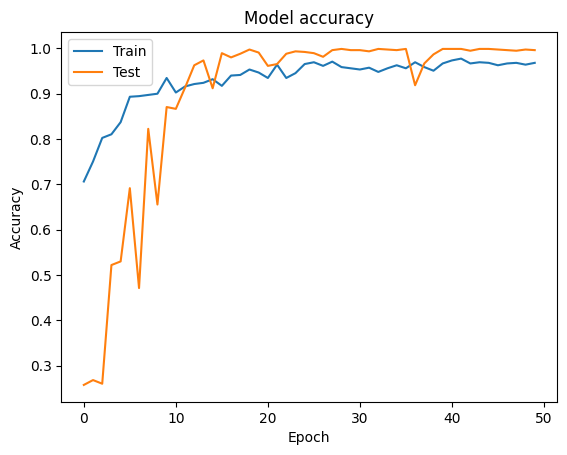

In [164]:
def train_CNN(CNN, x_train, y_train, x_val, y_val):
    Cnn.compile(optimizer=Adam(learning_rate=0.01), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    history = CNN.fit(
        x_train, y_train,
        epochs = 50,
        batch_size = 32,
        validation_data = (x_val, y_val))
    
    # Plot training & validation accuracy values
    # your code starts here
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    # your code ends here
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return history

x_val, y_val = x_train[-10000:], y_train[-10000:]
train_CNN(Cnn, x_train, y_train, x_val, y_val)

#### CNN Evaluation

In [165]:
y_pred = Cnn.predict(x_test).argmax(axis=1)
y2 = data['Class']

_, y_test_label = train_test_split(y2, random_state=0)
y_test_label = list(y_test_label)

y_pred = encoder.inverse_transform(y_pred)

print(classification_report(y_test_label,y_pred))


8/8 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

       blues       0.77      0.77      0.77        22
   classical       0.94      1.00      0.97        16
     country       0.94      0.53      0.68        30
       disco       0.86      0.70      0.78        27
      hiphop       0.96      0.84      0.90        31
        jazz       1.00      0.95      0.97        19
       metal       1.00      0.96      0.98        26
         pop       0.79      0.76      0.78        25
      reggae       0.69      0.79      0.73        28
        rock       0.50      0.88      0.64        26

    accuracy                           0.80       250
   macro avg       0.85      0.82      0.82       250
weighted avg       0.84      0.80      0.81       250


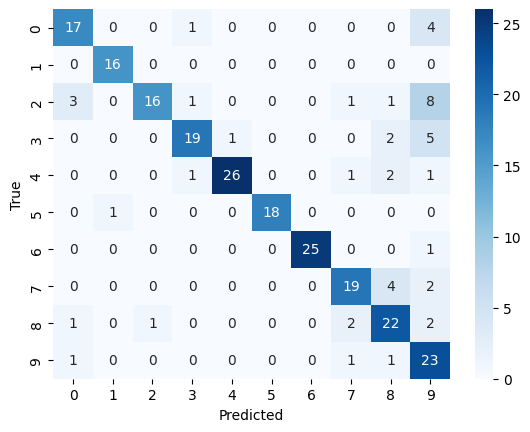

In [166]:
cm = confusion_matrix(y_test_label, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 5.2 Tune and evaluate models

##### DecisionTreeClassifier

max_depth : The maximum depth of the decision tree. The depth is the maximum number of layers the tree can grow. The deeper the tree is, the more detail it can capture about the data. However, if the tree is too deep, it may lead to overfitting, i.e., it performs well on training data but generalizes poorly on unseen data. Different depth values may correspond to different model complexity and generalization abilities. 

min_samples_split: minimum number of samples required for internal nodes to be further split. This parameter specifies the minimum number of samples a node must have to be further split. Larger values prevent the model from learning "noise" from the data, but may also lead to underfitting. 

min_samples_leaf: minimum number of samples at leaf nodes. This parameter limits the minimum number of samples that a leaf node (the output node of the decision tree) must have. Higher values smooth the model, especially in regression, which helps to avoid overfitting, but can lead to underfitting if set too high. 

In [253]:
Tree_grid = GridSearchCV(Tree,[{"max_depth":[10, 20, 30], 
                                "min_samples_split":[2, 4], 
                                "min_samples_leaf":[1, 2]}], 
                                scoring = "accuracy", cv=10)
Tree_grid.fit(x_train2, y_train2)
best_accuracy = Tree_grid.best_score_
bset_parameters = Tree_grid.best_params_
print("DecisionTreeClassifier", "\n best accuracy is:", best_accuracy)
print("best parameters are:", bset_parameters)

DecisionTreeClassifier 
 best accuracy is: 0.5357142857142857
best parameters are: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [254]:
y_pred = Tree_grid.predict(x_test2)
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

       blues       0.45      0.46      0.46        28
   classical       0.80      0.70      0.74        23
     country       0.35      0.35      0.35        31
       disco       0.52      0.45      0.48        31
      hiphop       0.42      0.42      0.42        33
        jazz       0.66      0.59      0.62        32
       metal       0.74      0.87      0.80        30
         pop       0.57      0.55      0.56        31
      reggae       0.43      0.48      0.45        31
        rock       0.23      0.23      0.23        30

    accuracy                           0.51       300
   macro avg       0.52      0.51      0.51       300
weighted avg       0.51      0.51      0.51       300


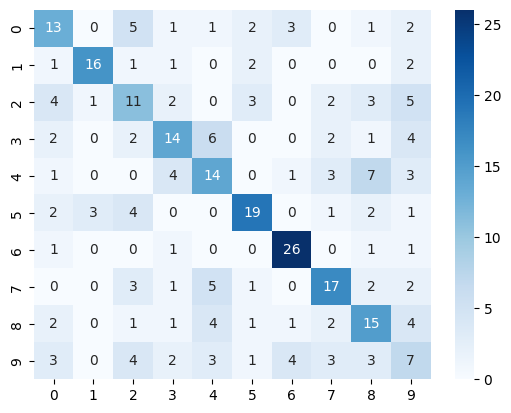

In [255]:
cfm = confusion_matrix(y_test2, y_pred)
sns.heatmap(cfm, annot=True, fmt = 'd', cmap='Blues')
plt.show()

##### RandomForestClassifier

n_estimators: number of trees in the forest. This indicates the number of decision trees that will be trained when building the random forest. More trees increase the stability and performance of the model, but also increase the computational cost and training time. In general, the more trees there are, the better the model performs until it reaches a saturation point.

max_depth: the maximum depth of the tree, the same as the max_depth parameter in a single decision tree. This parameter controls the depth of the tree, with larger depths allowing the model to learn features of the data more deeply. If max_depth is set too high, it may lead to overfitting; if it is set too low, it may lead to underfitting. 

min_samples_leaf: the minimum number of samples required for a leaf node, with the same meaning as the min_samples_leaf parameter in a single decision tree. This parameter specifies the minimum number of samples that each leaf node (the nodes at the end of the decision tree) needs to contain. Increasing this value prevents the model from learning about noise in the data and generally improves the model's ability to generalize. 

In [256]:
Rf_grid = GridSearchCV(Rf,[{"n_estimators":[100, 200], 
                            "max_depth":[10, 20], 
                            "min_samples_leaf":[1, 2]}], 
                            scoring = "accuracy", cv=10)
Rf_grid.fit(x_train2, y_train2)
best_accuracy = Rf_grid.best_score_
bset_parameters = Rf_grid.best_params_
print("RandomForestClassifier", "\n best accuracy is:", best_accuracy)
print("best parameters are:", bset_parameters)

RandomForestClassifier 
 best accuracy is: 0.6842857142857143
best parameters are: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}


In [257]:
y_pred = Rf_grid.predict(x_test2)
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

       blues       0.63      0.68      0.66        28
   classical       0.80      0.87      0.83        23
     country       0.63      0.71      0.67        31
       disco       0.49      0.55      0.52        31
      hiphop       0.85      0.70      0.77        33
        jazz       0.86      0.75      0.80        32
       metal       0.76      0.87      0.81        30
         pop       0.73      0.71      0.72        31
      reggae       0.63      0.61      0.62        31
        rock       0.46      0.40      0.43        30

    accuracy                           0.68       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.68      0.68      0.68       300


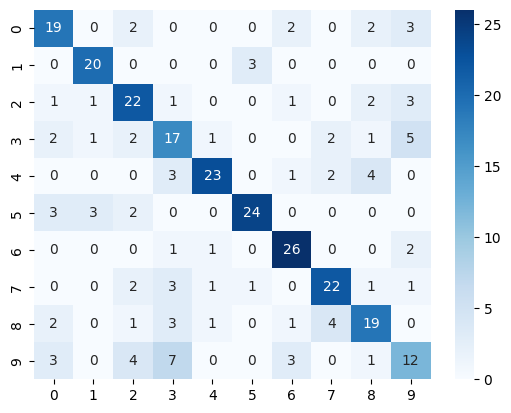

In [258]:
cfm = confusion_matrix(y_test2, y_pred)
sns.heatmap(cfm, annot=True, fmt = 'd', cmap='Blues')
plt.show()

##### LogisticRegression

C: the reciprocal of the strength of the regularization. A smaller value of C specifies stronger regularization, which means that the model minimizes the size of the weights to prevent overfitting; a larger value of C indicates weaker regularization, where the model may increase the complexity of the weights to better fit the data. In this given list of parameters, there are two duplicate 0.01 values, which may be an error and should have meaningfully different values for comparative model testing. 

solver: an algorithm for optimization problems. liblinear is suitable for small datasets, while saga is an extension of liblinear to support larger datasets and multi-class classification problems. saga is a stochastic optimization algorithm for large datasets and multi-classification problems.

penalty : Used to specify the type of penalty (regularization term). Regularization is a technique used to avoid model overfitting.

None means no regularization is used.

The l1 penalty results in sparse weights, i.e. many weights are zero, which can be useful for feature selection.

The l2 penalty is the standard form of regularization, which penalizes the sum of the squares of the weights and tends to spread out the magnitude of the weights rather than selectively setting them to zero.

In [263]:
Lr_grid = GridSearchCV(Lr,[{"C":[0.01, 0.01, 1.0], "solver":['liblinear', 'saga'], 
                            "penalty":['None','l1','l2']}], 
                            scoring = "accuracy", cv=10)
Lr_grid.fit(x_train2, y_train2)
best_accuracy = Lr_grid .best_score_
bset_parameters = Lr_grid .best_params_
print("LogisticRegression", "\n best accuracy is:", best_accuracy)
print("best parameters are:", bset_parameters)

d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-pac

LogisticRegression 
 best accuracy is: 0.6342857142857141
best parameters are: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}


d:\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python\lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "d:\Python\lib\site-packages\sklearn\base.py", line

In [260]:
y_pred = Lr_grid.predict(x_test2)
print(classification_report(y_test2,y_pred))

              precision    recall  f1-score   support

       blues       0.50      0.61      0.55        28
   classical       0.74      0.87      0.80        23
     country       0.74      0.45      0.56        31
       disco       0.61      0.45      0.52        31
      hiphop       0.85      0.52      0.64        33
        jazz       0.80      0.62      0.70        32
       metal       0.62      0.93      0.75        30
         pop       0.53      0.81      0.64        31
      reggae       0.62      0.58      0.60        31
        rock       0.42      0.43      0.43        30

    accuracy                           0.62       300
   macro avg       0.64      0.63      0.62       300
weighted avg       0.64      0.62      0.61       300


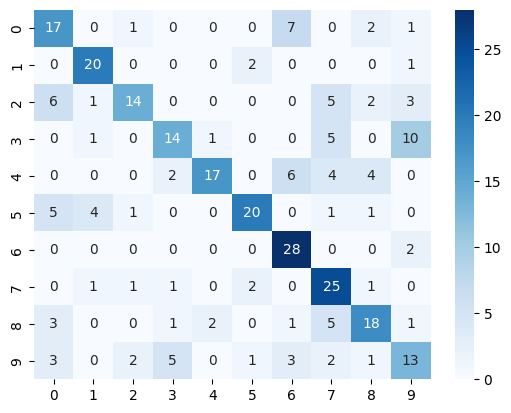

In [261]:
cfm = confusion_matrix(y_test2, y_pred)
sns.heatmap(cfm, annot=True, fmt = 'd', cmap='Blues')
plt.show()